In [68]:
import rospy
import rosbag
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [69]:
path = "/media/devansh/T7/bags_for_devansh"
save_path = "/home/devansh/csvs"
bag_extension = ".bag"
debug = False

In [70]:
def get_bag_names(bag_path):
    """Get bag names from directory
    Args:
        bag_path (str): path where bag files are stored
    Returns:
        bag_names (List[str]): list of bag names in bag_path
    """
    bag_names = []
    for file in os.listdir(bag_path):
        if file.endswith(bag_extension):
            bag_names.append(file)
    return bag_names

In [71]:
def get_data_from_bag(bag_name, bag_path):
    """Open bag, read data and return as lists
    Args:
        bag_name (str): name of bag
        bag_path (str): path of bag
    Returns:
        pressure_data (List[float]): list of time, pressure data
    """

    # open bag and handle unindexed bag exception
    try:
        bag = rosbag.Bag(os.path.join(bag_path, bag_name))
    except rosbag.bag.ROSBagUnindexedException:
        print(f"{bag_name} is unindexed. Index bag using 'rosbag index <bag_name>'.")
        print("Exiting...")
        exit(0)

    topics = bag.get_type_and_topic_info()[1].keys()
    if debug:
        print(topics)

    topic_name = "/dji_sdk/gps_position"
    # check if topic is in bag
    if "/uav1/dji_sdk/gps_position" in topics:
        topic_name = "/uav1/dji_sdk/gps_position"
    elif "/dji_sdk/gps_position" in topics:
        topic_name = "/dji_sdk/gps_position"
    else:
        print("Topic not found in bag")
        print("Skipping bag")
        return None

    if debug:
        print(topic_name)

    # height = []
    # create empty numpy array to store height
    height = np.empty((0, 2))

    for topic, msg, t in bag.read_messages(topic_name):
        # height.append([msg.header.stamp.secs + msg.header.stamp.nsecs/1e9] + [msg.altitude])
        # append time and height to numpy array
        height = np.append(
            height,
            [[msg.header.stamp.secs + msg.header.stamp.nsecs / 1e9, msg.altitude]],
            axis=0,
        )

        if debug:
            print(msg.header.stamp.secs + msg.header.stamp.nsecs / 1e9 - time)
            time = msg.header.stamp.secs + msg.header.stamp.nsecs / 1e9
            print(height)
    bag.close()
    return height

In [72]:
# get all folders in path
bag_paths = [
    os.path.join(path, folder)
    for folder in os.listdir(path)
    if os.path.isdir(os.path.join(path, folder))
]
print(bag_paths)

['/media/devansh/T7/bags_for_devansh/1_rossiter', '/media/devansh/T7/bags_for_devansh/2_confluence', '/media/devansh/T7/bags_for_devansh/3_reade']


In [73]:
# get bag names for all bag paths
bag_names = []  # list of lists
for bag_path in bag_paths:
    bag_names.append(get_bag_names(bag_path))
    # append path to bag name
    bag_names[-1] = [os.path.join(bag_path, bag_name) for bag_name in bag_names[-1]]
print(bag_names)

[['/media/devansh/T7/bags_for_devansh/1_rossiter/2021-11-07_19-20-26_dji_sdk_and_thermal.repaired.bag'], ['/media/devansh/T7/bags_for_devansh/2_confluence/2022-04-27_00-36-10.bag'], ['/media/devansh/T7/bags_for_devansh/3_reade/2022-11-08_14-00-58_dji_sdk_and_thermal.bag']]


In [74]:
# loop through all bag names and get height data (2d numpy array), store it into pandas dataframes
dataframes = []
for bag_path, bag_name in zip(bag_paths, bag_names):
    for bag in bag_name:
        # get height data, if None, skip bag
        height = get_data_from_bag(bag, bag_path)
        if height is None:
            continue
        # create dataframe
        df = pd.DataFrame(height, columns=["time", "height"])
        # append bag name to dataframe
        df["bag_name"] = bag
        # append dataframe to list of dataframes
        dataframes.append(df)

Topic not found in bag
Skipping bag


In [75]:
print(dataframes[0].shape)

(7484, 3)


In [76]:
# clean dataframes
for df in dataframes:
    # time starts from 0
    df["time"] = df["time"] - df["time"].iloc[0]
    # height starts from 0
    df["height"] = df["height"] - df["height"].iloc[0]

print(dataframes[0].head())

       time    height                                           bag_name
0  0.000000  0.000000  /media/devansh/T7/bags_for_devansh/1_rossiter/...
1  0.001790  0.010895  /media/devansh/T7/bags_for_devansh/1_rossiter/...
2  0.049179  0.021698  /media/devansh/T7/bags_for_devansh/1_rossiter/...
3  0.049603  0.033447  /media/devansh/T7/bags_for_devansh/1_rossiter/...
4  0.050223  0.045502  /media/devansh/T7/bags_for_devansh/1_rossiter/...


In [77]:
# save dataframes to csv in given folder but save folder structure. Do not include bag_name in csv
for df in dataframes:
    # get bag name
    bag_name = df["bag_name"].iloc[0]
    # get bag path
    bag_path = bag_name.split(bag_name.split("/")[-1])[0]
    # remove bag name from dataframe
    df = df.drop("bag_name", axis=1)
    # get folder name
    folder_name = bag_path.split("/")[-2]
    # create folder if it does not exist
    if not os.path.exists(os.path.join(save_path, folder_name)):
        os.makedirs(os.path.join(save_path, folder_name))
    # save dataframe to csv
    df.to_csv(
        os.path.join(
            save_path, folder_name, bag_name.split("/")[-1].split(".")[0] + ".csv"
        ),
        index=False,
    )

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


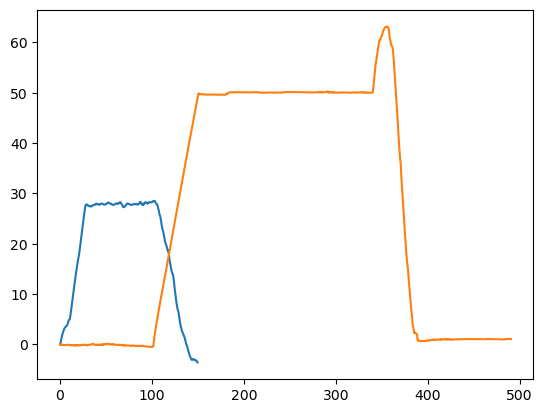

In [78]:
# plots
for df in dataframes:
    plt.plot(df["time"], df["height"])

plt.show()

## Plotting from CSVs

In [127]:
# load data from csvs and plot
csv_root_path = "/home/devansh/airlab/WIT-UAS-Asset-Detection/csvs/"
csv_paths = [
    os.path.join(csv_root_path, folder)
    for folder in os.listdir(csv_root_path)
    if os.path.isdir(os.path.join(csv_root_path, folder))
]
print(csv_paths)

['/home/devansh/airlab/WIT-UAS-Asset-Detection/csvs/confluence', '/home/devansh/airlab/WIT-UAS-Asset-Detection/csvs/reade', '/home/devansh/airlab/WIT-UAS-Asset-Detection/csvs/rossiter']


In [128]:
# find all csvs in csv_paths and store them as seperate dataframes
dataframes = []
for csv_path in csv_paths:
    for csv in os.listdir(csv_path):
        # read csv
        df = pd.read_csv(os.path.join(csv_path, csv))
        # append csv name to dataframe
        df["csv_name"] = csv
        # append dataframe to list of dataframes
        dataframes.append(df)
len(dataframes)

12

In [129]:
# magic rename dictionary given by the lord and savior himself
magic_rename_dict = {
    "2021-11-07_19-19-31": "Rossiter_1_flir",
    "2021-11-07_19-19-36": "Rossiter_2_flir",
    "2021-11-07_19-19-54": "Rossiter_3_flir",
    "2021-11-07_19-20-26": "Rossiter_4_flir",
    "2022-04-27_00-18-06": "Confluence_1_flir",
    "2022-04-27_00-18-06": "Confluence_2_seek",
    "2022-04-27_00-18-47": "Confluence_3_flir",
    "2022-04-27_00-18-47": "Confluence_4_seek",
    "2022-04-27_00-24-53": "Confluence_5_flir",
    "2022-04-27_00-24-53": "Confluence_6_seek",
    "2022-11-08_13-15-55": "Reade_1_seek",
    "2022-11-08_14-13-12": "Reade_2_seek",
    "2022-11-08_14-40-21": "Reade_3_seek",
}

corrupted_df_idx = []

# rename csv_name column to folder name as given by magic_rename_dict
for df in dataframes:
    # get csv name
    csv_name = df["csv_name"].iloc[0]
    # get folder name
    if len(csv_name.split("_")) < 3:
        folder_name = csv_name.split(".")[0]
    else:
        folder_name = csv_name.split("_")[0] + "_" + csv_name.split("_")[1]
    print(folder_name)
    # rename csv_name to folder name using magic_rename_dict
    # check if folder name is in magic_rename_dict
    if folder_name not in magic_rename_dict:
        print("Folder name not in magic_rename_dict")
        print(f"We will not plot this data: {df['csv_name'].iloc[0]}")
        # save idx of this dataframe, to be removed later
        # corrupted_df_idx.append(dataframes.index(df))
        continue
    df["csv_name"] = magic_rename_dict[folder_name]
    print(df.head())

2022-04-27_00-18-47
       time    height           csv_name
0  0.000000  0.000000  Confluence_4_seek
1  0.015339 -0.001160  Confluence_4_seek
2  0.032884 -0.001099  Confluence_4_seek
3  0.052430 -0.000732  Confluence_4_seek
4  0.071741 -0.000427  Confluence_4_seek
2022-04-27_00-18-06
       time    height           csv_name
0  0.000000  0.000000  Confluence_2_seek
1  0.019241 -0.000549  Confluence_2_seek
2  0.038687 -0.001587  Confluence_2_seek
3  0.062542 -0.002258  Confluence_2_seek
4  0.086846 -0.002197  Confluence_2_seek
2022-04-27_00-24-53
       time    height           csv_name
0  0.000000  0.000000  Confluence_6_seek
1  0.007951 -0.001343  Confluence_6_seek
2  0.026295 -0.001953  Confluence_6_seek
3  0.045547 -0.002747  Confluence_6_seek
4  0.073308 -0.002441  Confluence_6_seek
2022-11-08_14-40-21
       time    height      csv_name
0  0.000000  0.000000  Reade_3_seek
1  0.019927  0.003387  Reade_3_seek
2  0.037666  0.002930  Reade_3_seek
3  0.058980  0.000031  Reade_3_seek
4 

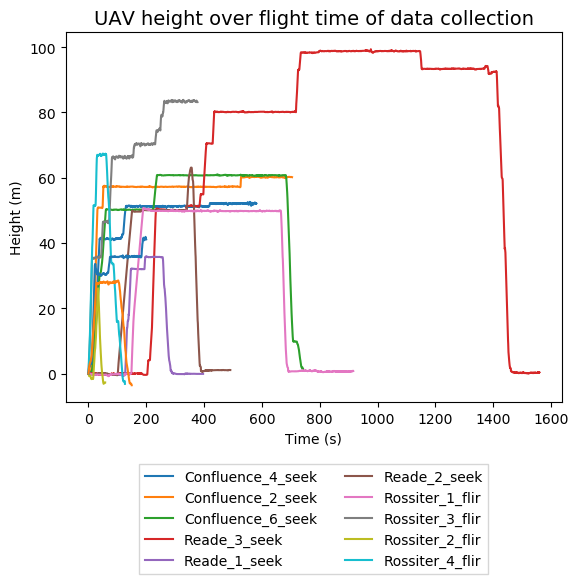

In [138]:
# plot all dataframes on same plot
for df in dataframes:
    plt.plot(df["time"], df["height"])

# add titles and axis labels
plt.title("UAV height over flight time of data collection", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

# only take dataframes whose csv_name is in magic_rename_dict for plotting
plot_dataframes = []
for df in dataframes:
    if df["csv_name"].iloc[0] in magic_rename_dict.values():
        plot_dataframes.append(df)

# add legend below the plot
plt.legend(
    [df["csv_name"].iloc[0] for df in plot_dataframes],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=False,
    shadow=False,
    ncol=2,
)
# plt.legend([df['csv_name'].iloc[0] for df in dataframes])